# Setup

In [1]:
import torch
from torch import nn
# from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm
import json

from torchmetrics import Accuracy

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [2]:
from IPython.display import clear_output
import os, sys, shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# from tqdm import tqdm, trange
from glob import glob
import random

import cv2 as cv

In [3]:
print(os.getcwd())

D:\GitCloneProject\HeartResearch\Experiment\Approach\EfficientB0


In [4]:
for i in range(3):
    os.chdir("..")

print(os.getcwd())

D:\GitCloneProject\HeartResearch


In [5]:
# D:\GitCloneProject\HeartResearch\Data set\v4_data\med_scaleogram_h256_w512_seglen1600_scl500
main_data_dir = os.getcwd() + "\\Data set"

label_csv_path = main_data_dir + "\\"

lead = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
lead_to_onehot = {leads : torch.nn.functional.one_hot(torch.tensor([index])[0], num_classes = 12) for index, leads in enumerate(lead)}

class_la = [1,2,3,4,5,6,7,8,9]
class_to_onehot = {classes : torch.nn.functional.one_hot(torch.tensor([index])[0], num_classes = 9) for index, classes in enumerate(class_la)}

img_data_dir = main_data_dir + "\\Data_set_scale500"
img_data_list =  glob(img_data_dir + "\\*")

print(len(os.listdir(img_data_dir)))

21958


In [ ]:
main_data_dir = os.getcwd() + "\Data set"
print(os.listdir(main_data_dir))
data_set_list = glob.glob(main_data_dir + "\\Data_set_scale{}\\*".format(scale))
label_list = []
lead_list = []
image_list = []
for img_path in data_set_list:
    img_name = img_path.split('\\')[-1].removesuffix('.png')
    img_signal = img_name.split('_')[0]
    img_lead = img_name.split('_')[1].replace('lead','')
    label_list.append(label_df[label_df["Recording"] == img_signal]["First_label"].values.tolist()[0])
    lead_list.append(img_lead)
    image_list.append(img_name)
dataset_df = pd.DataFrame({"Image": image_list,
                         "Class": label_list,
                         "Lead": lead_list})
dataset_df = dataset_df.sample(frac = 1)
dataset_df.to_csv(main_data_dir + "\\Data_set_scale{}\\dataset".format(scale))

In [7]:
print(img_data_list[0])

D:\GitCloneProject\HeartResearch\Data set\Data_set_scale500\A0001_leadaVF_seg4.png


In [8]:
label_df = pd.read_csv(main_data_dir+"\\dataset")
label_df.head()

,Unnamed: 0,Image,Class,Lead
0,6967,A2265_leadV3_seg5,4,V3
1,8124,A2630_leadaVF_seg8,3,aVF
2,21408,A6700_leadV3_seg1,5,V3
3,12612,A3997_leadIII_seg6,7,III
4,12547,A3979_leadV2_seg3,8,V2


In [9]:
label_df["Class"][0]

4

 # Data Loader

In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn.functional import one_hot

In [11]:
torch.cuda.is_available()

True

In [12]:
ratio = [0.8, 0.1, 0.1]

train_index = int(len(img_data_list)*ratio[0])
valid_index = int(len(img_data_list)*(ratio[0]+ratio[1]))

train_image_paths = img_data_list[:train_index]
valid_image_paths = img_data_list[train_index:valid_index]
test_image_paths = img_data_list[valid_index:]

train_label = label_df.iloc[:train_index,:]
valid_label = label_df.iloc[train_index:valid_index,:]
test_label = label_df.iloc[valid_index:,:]

print(len(train_image_paths))
print(len(valid_image_paths))
print(len(test_image_paths))

print(train_label.shape)
print(valid_label.shape)
print(test_label.shape)

17566
2196
2196
(17566, 4)
(2196, 4)
(2196, 4)


In [13]:
train_image_paths[0]

'D:\\GitCloneProject\\HeartResearch\\Data set\\Data_set_scale500\\A0001_leadaVF_seg4.png'

In [14]:
train_label

,Unnamed: 0,Image,Class,Lead
0,6967,A2265_leadV3_seg5,4,V3
1,8124,A2630_leadaVF_seg8,3,aVF
2,21408,A6700_leadV3_seg1,5,V3
3,12612,A3997_leadIII_seg6,7,III
4,12547,A3979_leadV2_seg3,8,V2
...,...,...,...,...
17561,6767,A2202_leadV1_seg1,3,V1
17562,596,A0173_leadaVL_seg3,1,aVL
17563,11521,A3647_leadV6_seg5,6,V6
17564,5307,A1698_leadII_seg2,1,II


In [15]:
class HeartData(Dataset):
    def __init__(self, label_df, data_path):
        self.label_df = label_df
        self.data_path = data_path
        
#         self.onehot_label_class = one_hot(self.label_df['Class'])
#         self.onehot_label_lead = one_hot(self.label_df['Lead'])
    def __len__(self):
        return len(self.data_path)
        
    def __getitem__(self, index):
#         imgs = []
#         labels = []
#         labels.append(self.onehot_label_class)
#         labels.append(self.onehot_label_lead)
        class_label = self.label_df['Class'][index]
        class_label = class_to_onehot[class_label]
    
        lead_label = self.label_df['Lead'][index]
        lead_label = lead_to_onehot[lead_label]

        data_img = cv.imread(self.data_path[index])
        torch_img = torch.from_numpy(data_img).permute(-1, 0, 1)
        
#         lead_label = self.onehot_label_lead[index]
#         class_label = self.onehot_label_class[index]
        
        return lead_label, class_label, torch_img

In [16]:
class_label = train_label['Class'][0]
class_label = class_to_onehot[class_label]
print(type(class_label))
lead_label = train_label['Lead'][0]
lead_label = lead_to_onehot[lead_label]
print(type(lead_label))
data_img = cv.imread(train_image_paths[1])
torch_img = torch.from_numpy(data_img).permute(-1, 0, 1)
print(type(torch_img))
print(torch_img.shape)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([3, 253, 506])


In [17]:
train_dataset = HeartData(label_df, train_image_paths)
valid_dataset = HeartData(label_df, valid_image_paths)
test_dataset = HeartData(label_df, test_image_paths)

In [18]:
len(valid_dataset)

2196

In [19]:
valid_dataset[5]

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 tensor([0, 0, 0, 1, 0, 0, 0, 0, 0]),
 tensor([[[128, 128, 128,  ..., 128, 128, 128],
          [128, 128, 128,  ..., 128, 128, 132],
          [132, 132, 128,  ..., 132, 137, 146],
          ...,
          [223, 255, 214,  ..., 227, 255, 250],
          [232, 255, 218,  ..., 255, 255, 250],
          [241, 200, 237,  ..., 255, 237, 255]],
 
         [[  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          ...,
          [  0,   0,   0,  ...,   0,  25,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   1]],
 
         [[  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]]]

In [20]:
train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle = True, pin_memory = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 16, shuffle = True, pin_memory = True)
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = True, pin_memory = True)

In [21]:
len(train_dataloader)

1098

In [22]:
# multi-task learning - efficient B0
# data loader -> 2 labels: lead + disease
# Model: 2 output: 1 vector for 12 leads (softmax) + 1 vector for disease
# loss funct: loss lead + loss class => backward
# random choice: notice: seed(python, numpy, torch) same
        
# multi-channel - efficient B2 - quite similar to video classification

# Model 

In [23]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch import nn

ori_model = efficientnet_b0(weights = EfficientNet_B0_Weights.IMAGENET1K_V1)

In [24]:
# ori_model

In [25]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch import nn

class HeartModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.ori_model = efficientnet_b0(weights = EfficientNet_B0_Weights.IMAGENET1K_V1)
        del self.ori_model.classifier
        self.ori_model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, 21),
            nn.Softmax(dim = 1)
        )
        
    def forward(self, x):        
        logits = self.ori_model(x)
        
        return (logits[:, :12], logits[:, 12:])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HeartModel().to(device)
print(model)

HeartModel(
  (ori_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_

# Training

In [26]:
from datetime import datetime

opt_mapping = {
    "Adam" : torch.optim.Adam
}

loss_mapping = {
    "CCE" : nn.CrossEntropyLoss()
}

class Training:
    def __init__(self, 
                 device: str = "cpu",
                 learning_rate:float = 0.0001,
                 optimizer:str = "Adam",
                 loss:str = "CCE",
                 model = model,
#                  batchsize:int = 32,
                 epochs:int = 100,
#                  label_df: pd.DataFrame = label_df, 
#                  root_dir: str = img_data_dir, 
#                  ratio: tuple = (0.8, 0.1, 0.1),
#                  resize: tuple = None, #  (256, 512)
#                  seed: int = 777
                ):
        
        # Setup
        self.device = device
        self.model = model
        self.model.to(self.device)
        self.lr = learning_rate
        self.optimizer = opt_mapping[optimizer](self.model.parameters(), lr=self.lr)
        self.loss_fn = loss_mapping[loss]
        self.ep = epochs
        self.lead_accuracy = Accuracy(task="multiclass", num_classes=12).to(self.device)
        self.cls_accuracy = Accuracy(task="multiclass", num_classes=9).to(self.device)
        
        # Data
        self.train_data = train_dataloader
        self.valid_data = valid_dataloader
        self.test_data = test_dataloader
    
    train_losses = []
    val_losses = []
    
    def __update__(self):
        for e in range(self.ep):
            train_class_acc = 0
            train_lead_acc = 0
            batch_cnt = 0
            self.model.train()
            for batch, (y1, y2, X) in tqdm(enumerate(self.train_data)):
                batch_cnt = batch
                y1, y2 = y1.to(self.device), y2.to(self.device)
                pred1, pred2 = self.model((X/255).to(self.device))
                l1 = self.loss_fn(pred1, y1.to(self.device, dtype = torch.float))
                l2 = self.loss_fn(pred2, y2.to(self.device, dtype = torch.float))
                train_loss = l1 + l2
                train_losses.append(train_loss)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                train_lead_acc += self.lead_accuracy(torch.argmax(pred1, dim = 1), torch.argmax(y1, dim = 1)).item()
                train_class_acc += self.cls_accuracy(torch.argmax(pred2, dim = 1), torch.argmax(y2, dim = 1)).item()
                        
            mean_train_cls_acc = train_class_acc/(batch_cnt + 1)
            mean_train_led_acc = train_lead_acc/(batch_cnt + 1)
            # Show train_loss, train_acc, val_loss, val_acc
            if e%10 == 0: 
                print(f"Epoch: {e} - Train Loss: {loss.item()} - Train class acc: {mean_train_cls_acc} - Train lead acc: {mean_train_led_acc}")
#             " - Val Loss: {val_loss.item()} - Val Acc: {val_acc.item()}")

            self.validation()
        loss_plot(self, train_losses = train_losses, val_losses = val_losses, n_epochs = e + 1, check_folder = 'run_efficientB0')
        self.evaluation()
        
    def validation(self):
        self.model.eval()
        valid_class_acc = 0
        valid_lead_acc = 0
        batch_cnt = 0
        
        with torch.no_grad():
            valid_class_acc = 0
            valid_lead_acc = 0
            batch_cnt = 0
            for batch, (y1, y2, X) in tqdm(enumerate(self.valid_data)):
                batch_cnt = batch

                y1, y2 = y1.to(self.device), y2.to(self.device)
                pred1, pred2 = self.model((X/255).to(self.device))

                l1 = self.loss_fn(pred1, y1.to(self.device, dtype = torch.float))
                l2 = self.loss_fn(pred2, y2.to(self.device, dtype = torch.float))
                val_loss = l1 + l2
                val_losses.append(val_loss)

                valid_lead_acc += self.lead_accuracy(torch.argmax(pred1, dim = 1), torch.argmax(y1, dim = 1)).item()
                valid_class_acc += self.cls_accuracy(torch.argmax(pred2, dim = 1), torch.argmax(y2, dim = 1)).item()                

            mean_valid_cls_acc = valid_class_acc/(batch_cnt + 1)
            mean_valid_led_acc = valid_lead_acc/(batch_cnt + 1)

            self.checkpoint(valid_lead_acc = mean_valid_cls_acc, 
                       valid_class_acc = mean_valid_led_acc, 
                       val_total_loss = loss,
                       epoch = epoch, 
                       model = self.model,
                       optimizer = self.optimizer,
                       check_folder = 'run_efficientB0')

            print(f"Val_loss: {loss.item()} - Val class acc: {mean_valid_cls_acc} - Val lead acc: {mean_valid_led_acc}")
        
        return val_loss, mean_valid_cls_acc, mean_valid_led_acc

    def loss_plot(self, train_losses, val_losses, n_epochs, check_folder):
        now = datetime.now().strftime("%m-%d-%Y - %H-%M-%S")
        run_dir = os.getcwd() + f"/{check_folder}"
        if not os.path.exists(run_dir):
            os.mkdir(run_dir)
        save_dir = run_dir + f"/{now}"
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_loss_dir = save_dir + "\save_losses"
        if not os.path.exists(save_loss_dir):
            os.mkdir(save_loss_dir)
        save_fig_losses = os.path.join(save_loss_dir, 'plot_losses.png')  
        
        plt.figure()
        plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
        plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        # plt.xticks()
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.savefig(save_fig_losses)
    
    def checkpoint(self, valid_lead_acc, valid_class_acc, 
                   val_total_loss,
                   epoch, 
                   model,
                   optimizer,
                   check_folder
#                    logs
                  ):
        old_valid_lead_acc = 0
        old_valid_class_acc = 0
        old_valid_loss = 1e23
        if valid_lead_acc >= old_valid_lead_acc and valid_class_acc >= old_valid_class_acc and val_total_loss <= old_valid_loss:
            old_valid_lead_acc = valid_lead_acc
            old_valid_class_acc = valid_class_acc
            old_valid_loss = val_total_loss
            save_dict = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_total_loss,
                'val_lead_acc': valid_lead_acc,
                'val_class_acc': valid_class_acc
            }
            
         # Saving best model
        now = datetime.now().strftime("%m-%d-%Y - %H-%M-%S")
        run_dir = os.getcwd() + f"/{check_folder}"
        if not os.path.exists(run_dir):
            os.mkdir(run_dir)
        save_dir = run_dir + f"/{now}"
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_best_model_dir = save_dir + "\save_best_model"
        if not os.path.exists(save_best_model_dir):
            os.mkdir(save_best_model_dir)
        save_best_model_path = save_best_model_dir + f"/{save_dict['loss']:>7f}_{save_dict['val_lead_acc']:>7f}_{save_dict['val_class_acc']:>7f}_{now}.pt"
        torch.save(save_dict, save_best_model_path)

#         config_path = save_dir + '/config.json'
#         with open(config_path, mode='w') as file:
#             json.dump(vars(args), file)
    
    def evaluation(self):
        
        self.model.eval()
        
        y1_eval = [] 
        y2_eval = []
        pred1_eval = []
        pred2_eval = []
        
        with torch.no_grad():
            for batch, (y1, y2, X) in tqdm(enumerate(self.test_data)):
                batch_cnt = batch
                
                y1, y2 = y1.to(self.device), y2.to(self.device)
                pred1, pred2 = self.model((X/255).to(self.device))
                
                y1_eval.append(torch.argmax(y1, dim=1)[0])
                y2_eval.append(torch.argmax(y2, dim=1)[0])
                pred1_eval.append(torch.argmax(pred1, dim=1)[0])
                pred2_eval.append(torch.argmax(pred2, dim=1)[0])
                
            y1_eval = torch.stack(y1_eval)
            y2_eval = torch.stack(y2_eval)
            pred1_eval = torch.stack(pred1_eval)
            pred2_eval = torch.stack(pred2_eval)
                
            pred1 = torch.nn.functional.one_hot(pred1_eval, num_classes = 12)
            pred2 = torch.nn.functional.one_hot(pred2_eval, num_classes = 9)
            y1 = torch.nn.functional.one_hot(y1_eval, num_classes = 12)
            y2 = torch.nn.functional.one_hot(y2_eval, num_classes = 9)
            print(y1)
            print(y2)
            print(pred1)
            print(pred2)
            print(y2_eval)
            print(pred2_eval)
            print(torch.argmax(y1, dim=1).cpu().numpy()[0].tolist())
            print(torch.argmax(y1, dim=1).cpu().numpy().tolist())
            
            # Classification report
            for i in range (len(class_la)):
                class_la[i] = str(class_la[i])

            # Classification report
            print(classification_report(
                torch.argmax(y1, dim=1).cpu().numpy().tolist(), 
                torch.argmax(pred1, dim=1).cpu().numpy().tolist(),
                target_names=lead))    
            

            print(classification_report(
                torch.argmax(y2, dim=1).cpu().numpy().tolist(), 
                torch.argmax(pred2, dim=1).cpu().numpy().tolist(), 
                target_names=class_la)) 

            # Confusion Matrix
            ConfusionMatrixDisplay.from_predictions(torch.argmax(y1, dim=1).cpu().numpy().tolist(), torch.argmax(pred1, dim=1).cpu().numpy().tolist(), cmap = "PuBuGn")
            plt.show()

            ConfusionMatrixDisplay.from_predictions(torch.argmax(y2, dim=1).cpu().numpy().tolist(), torch.argmax(pred2, dim=1).cpu().numpy().tolist(), cmap = "PuBuGn")
            plt.show()

            # ROC Curve
            for i in range(12):
                r1 = roc_auc_score(y1[:, i].cpu(), pred1[:, i].cpu())
                print("The ROC AUC score of "+ lead[i] +" is: "+str(r1))

            for i in range(9):
                r2 = roc_auc_score(y2[:, i].cpu(), pred2[:, i].cpu())
                print("The ROC AUC score of "+ class_la[i] +" is: "+str(r2))

            # Compute ROC curve and ROC area for each lead
            lead_fpr = {}
            lead_tpr = {}
            roc_auc = {}
            lead_roc_auc = dict()
            for i in range(12):
                lead_fpr[i], lead_tpr[i], _ = roc_curve(y1[:, i].cpu(), pred1[:, i].cpu(), drop_intermediate=False)
                roc_auc[i] = auc(lead_fpr[i], lead_tpr[i])

            plt.plot(lead_fpr[0], lead_tpr[0],'turquoise',label=f'I: ROC curve of {lead[0]} (area = %0.2f)' % roc_auc[0])
            plt.plot(lead_fpr[1], lead_tpr[1],'peachpuff',label=f'II: ROC curve of {lead[1]} (area = %0.2f)' % roc_auc[1])
            plt.plot(lead_fpr[2], lead_tpr[2],'paleturquoise',label=f'III: ROC curve of {lead[2]} (area = %0.2f)' % roc_auc[2])
            plt.plot(lead_fpr[3], lead_tpr[3],'pink',label=f'aVR: ROC curve of {lead[3]} (area = %0.2f)' % roc_auc[3])
            plt.plot(lead_fpr[4], lead_tpr[4],'lightcoral',label=f'aVL: ROC curve of {lead[4]} (area = %0.2f)' % roc_auc[4])
            plt.plot(lead_fpr[5], lead_tpr[5],'peachpuff',label=f'aVF: ROC curve of {lead[5]} (area = %0.2f)' % roc_auc[5])
            plt.plot(lead_fpr[6], lead_tpr[6],'steelblue',label=f'V1: ROC curve of {lead[6]} (area = %0.2f)' % roc_auc[6])
            plt.plot(lead_fpr[7], lead_tpr[7],'forestgreen',label=f'V2: ROC curve of {lead[7]} (area = %0.2f)' % roc_auc[7])
            plt.plot(lead_fpr[8], lead_tpr[8],'darkslategray',label=f'V3: ROC curve of {lead[8]} (area = %0.2f)' % roc_auc[8])
            plt.plot(lead_fpr[9], lead_tpr[9],'orange',label=f'V4: ROC curve of {lead[9]} (area = %0.2f)' % roc_auc[9])
            plt.plot(lead_fpr[10], lead_tpr[10],'maroon',label=f'V5: ROC curve of {lead[10]} (area = %0.2f)' % roc_auc[10])
            plt.plot(lead_fpr[11], lead_tpr[11],'navy',label=f'V6: ROC curve of {lead[11]} (area = %0.2f)' % roc_auc[11])

            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([-0.1, 1.1])
            plt.ylim([-0.1, 1.1])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver operating characteristic of class')
            plt.legend(loc="lower right")
            plt.show()

            # Compute ROC curve and ROC area for each class
            class_fpr = {}
            class_tpr = {}
            class_roc_auc = dict()
            for i in range(9):
                class_fpr[i], class_tpr[i], _ = roc_curve(y2[:, i].cpu(), pred2[:, i].cpu(), drop_intermediate=False)
                roc_auc[i] = auc(class_fpr[i], class_tpr[i])

            plt.plot(class_fpr[0], class_tpr[0],'turquoise',label='1: ROC curve of class 1 (area = %0.2f)' % roc_auc[0])
            plt.plot(class_fpr[1], class_tpr[1],'peachpuff',label='2: ROC curve of class 2 (area = %0.2f)' % roc_auc[1])
            plt.plot(class_fpr[2], class_tpr[2],'paleturquoise',label='3: ROC curve of class 3 (area = %0.2f)' % roc_auc[2])
            plt.plot(class_fpr[3], class_tpr[3],'pink',label='4: ROC curve of class 4 (area = %0.2f)' % roc_auc[3])
            plt.plot(class_fpr[4], class_tpr[4],'lightcoral',label='5: ROC curve of class 5 (area = %0.2f)' % roc_auc[4])
            plt.plot(class_fpr[5], class_tpr[5],'peachpuff',label='6: ROC curve of class 6 (area = %0.2f)' % roc_auc[5])
            plt.plot(class_fpr[6], class_tpr[6],'steelblue',label='7: ROC curve of class 7 (area = %0.2f)' % roc_auc[6])
            plt.plot(class_fpr[7], class_tpr[7],'forestgreen',label='8: ROC curve of class 8 (area = %0.2f)' % roc_auc[6])
            plt.plot(class_fpr[8], class_tpr[8],'darkslategray',label='9: ROC curve of class 9 (area = %0.2f)' % roc_auc[6])

            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([-0.1, 1.1])
            plt.ylim([-0.1, 1.1])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver operating characteristic of lead')
            plt.legend(loc="lower right")
            plt.show()          

1098it [03:50,  4.77it/s]


Epoch: 0 - Train Loss: 4.695856094360352 - Train class acc: 0.11568110851479359 - Train lead acc: 0.0860655737704918


1098it [03:47,  4.82it/s]


Epoch: 1 - Train Loss: 4.690061569213867 - Train class acc: 0.12467473328710688 - Train lead acc: 0.09409966172552066


1098it [03:48,  4.81it/s]


Epoch: 2 - Train Loss: 4.6933698654174805 - Train class acc: 0.12796805881113085 - Train lead acc: 0.0989380041663221


1098it [03:48,  4.81it/s]


Epoch: 3 - Train Loss: 4.662766456604004 - Train class acc: 0.13800253708234467 - Train lead acc: 0.10655737704918032


1098it [03:48,  4.81it/s]


Epoch: 4 - Train Loss: 4.706701755523682 - Train class acc: 0.14584146500420916 - Train lead acc: 0.11316842310985581


1098it [03:48,  4.81it/s]


Epoch: 5 - Train Loss: 4.72249698638916 - Train class acc: 0.15376170960768976 - Train lead acc: 0.12278005464480875


1098it [03:48,  4.80it/s]


Epoch: 6 - Train Loss: 4.685144424438477 - Train class acc: 0.16617063492645115 - Train lead acc: 0.13612412178179822


1098it [03:48,  4.81it/s]


Epoch: 7 - Train Loss: 4.591561317443848 - Train class acc: 0.18178343743031578 - Train lead acc: 0.15159868592827264


1098it [03:48,  4.81it/s]


Epoch: 8 - Train Loss: 4.536474704742432 - Train class acc: 0.198347645080589 - Train lead acc: 0.17016328389473084


1098it [03:48,  4.81it/s]


Epoch: 9 - Train Loss: 4.687395095825195 - Train class acc: 0.21774167317781726 - Train lead acc: 0.1850686312834639


1098it [03:48,  4.81it/s]


Epoch: 10 - Train Loss: 4.632169723510742 - Train class acc: 0.23771304970366272 - Train lead acc: 0.19977068697494235


1098it [03:48,  4.81it/s]


Epoch: 11 - Train Loss: 4.525282859802246 - Train class acc: 0.2590261514558167 - Train lead acc: 0.2186524199902034


1098it [03:48,  4.81it/s]


Epoch: 12 - Train Loss: 4.469931125640869 - Train class acc: 0.27394776217273026 - Train lead acc: 0.23197209212135095


1098it [03:48,  4.81it/s]


Epoch: 13 - Train Loss: 4.430507659912109 - Train class acc: 0.2900484647527201 - Train lead acc: 0.2465521727836197


1098it [03:48,  4.81it/s]


Epoch: 14 - Train Loss: 4.640477657318115 - Train class acc: 0.3081983476470077 - Train lead acc: 0.2540007806459411


1098it [03:48,  4.81it/s]


Epoch: 15 - Train Loss: 4.164031028747559 - Train class acc: 0.324063231873382 - Train lead acc: 0.26826372625940703


1098it [03:48,  4.80it/s]


Epoch: 16 - Train Loss: 4.314075469970703 - Train class acc: 0.33860265418805713 - Train lead acc: 0.2750943273523032


1098it [03:48,  4.81it/s]


Epoch: 17 - Train Loss: 4.529565811157227 - Train class acc: 0.35136124122555357 - Train lead acc: 0.28569802238125835


1098it [03:48,  4.81it/s]


Epoch: 18 - Train Loss: 4.273880958557129 - Train class acc: 0.3662909836065574 - Train lead acc: 0.2947160421661992


1098it [03:48,  4.81it/s]


Epoch: 19 - Train Loss: 4.49522066116333 - Train class acc: 0.3757643767909057 - Train lead acc: 0.30120511320445054


1098it [03:48,  4.80it/s]


Epoch: 20 - Train Loss: 4.227099418640137 - Train class acc: 0.3876366120218579 - Train lead acc: 0.3105809263654311


1098it [03:48,  4.81it/s]


Epoch: 21 - Train Loss: 4.218618392944336 - Train class acc: 0.4017857142973467 - Train lead acc: 0.31715131408529856


1098it [03:48,  4.80it/s]


Epoch: 22 - Train Loss: 4.438477516174316 - Train class acc: 0.40913674213630036 - Train lead acc: 0.32338017174373557


1098it [03:48,  4.81it/s]


Epoch: 23 - Train Loss: 4.258450508117676 - Train class acc: 0.4183011319359361 - Train lead acc: 0.33094262295081966


1098it [03:48,  4.81it/s]


Epoch: 24 - Train Loss: 4.327910423278809 - Train class acc: 0.4245218579234973 - Train lead acc: 0.33700884726638136


1098it [03:48,  4.81it/s]


Epoch: 25 - Train Loss: 4.125775337219238 - Train class acc: 0.43902875358181137 - Train lead acc: 0.33969229769185594


1098it [03:48,  4.81it/s]


Epoch: 26 - Train Loss: 4.397661209106445 - Train class acc: 0.44757513661202186 - Train lead acc: 0.34137555295923805


1098it [03:48,  4.80it/s]


Epoch: 27 - Train Loss: 4.285195350646973 - Train class acc: 0.45865860005979764 - Train lead acc: 0.3515889279286501


1098it [03:48,  4.80it/s]


Epoch: 28 - Train Loss: 4.051804065704346 - Train class acc: 0.4625943273523032 - Train lead acc: 0.35353239656906094


1098it [03:48,  4.80it/s]


Epoch: 29 - Train Loss: 4.127025127410889 - Train class acc: 0.47484061930783245 - Train lead acc: 0.35689890710382516


1098it [03:48,  4.81it/s]


Epoch: 30 - Train Loss: 4.306998252868652 - Train class acc: 0.48048399690070437 - Train lead acc: 0.3618104345621524


1098it [03:48,  4.81it/s]


Epoch: 31 - Train Loss: 4.004485607147217 - Train class acc: 0.4848181758964865 - Train lead acc: 0.3675432604735883


1098it [03:48,  4.80it/s]


Epoch: 32 - Train Loss: 4.214903831481934 - Train class acc: 0.4925920504852722 - Train lead acc: 0.36582747853627406


1098it [03:48,  4.80it/s]


Epoch: 33 - Train Loss: 4.1503448486328125 - Train class acc: 0.4995364949297167 - Train lead acc: 0.3719587561917001


1098it [03:48,  4.80it/s]


Epoch: 34 - Train Loss: 3.9217445850372314 - Train class acc: 0.5075787145691926 - Train lead acc: 0.3757969034608379


1098it [03:48,  4.80it/s]


Epoch: 35 - Train Loss: 4.083324909210205 - Train class acc: 0.5145719489981785 - Train lead acc: 0.37664259693335966


1098it [03:48,  4.80it/s]


Epoch: 36 - Train Loss: 4.314546585083008 - Train class acc: 0.5138157038849342 - Train lead acc: 0.37987086912430484


1098it [03:48,  4.81it/s]


Epoch: 37 - Train Loss: 4.118413925170898 - Train class acc: 0.5249072989968003 - Train lead acc: 0.384457129869739


1098it [03:48,  4.80it/s]


Epoch: 38 - Train Loss: 4.233880043029785 - Train class acc: 0.5284120479025258 - Train lead acc: 0.38418878480547763


1098it [03:48,  4.81it/s]


Epoch: 39 - Train Loss: 4.094294548034668 - Train class acc: 0.5356248373705181 - Train lead acc: 0.3929709862164461


1098it [03:48,  4.80it/s]


Epoch: 40 - Train Loss: 4.145437717437744 - Train class acc: 0.5368445875540457 - Train lead acc: 0.38886449389661815


1098it [03:48,  4.81it/s]


Epoch: 41 - Train Loss: 4.132613182067871 - Train class acc: 0.5438784803577676 - Train lead acc: 0.3961016783840235


1098it [03:48,  4.80it/s]


Epoch: 42 - Train Loss: 4.0817975997924805 - Train class acc: 0.543911007041271 - Train lead acc: 0.39524785324741146


1098it [03:48,  4.80it/s]


Epoch: 43 - Train Loss: 4.222622871398926 - Train class acc: 0.5484403460837887 - Train lead acc: 0.39506895655599883


1098it [03:48,  4.80it/s]


Epoch: 44 - Train Loss: 4.220801830291748 - Train class acc: 0.5577185792349727 - Train lead acc: 0.39467050482557986


1098it [03:48,  4.81it/s]


Epoch: 45 - Train Loss: 4.2428131103515625 - Train class acc: 0.5607760863985954 - Train lead acc: 0.4011189175162376


1098it [03:48,  4.81it/s]


Epoch: 46 - Train Loss: 4.061785697937012 - Train class acc: 0.5656469554957579 - Train lead acc: 0.4031599661800162


1098it [03:48,  4.81it/s]


Epoch: 47 - Train Loss: 3.9829697608947754 - Train class acc: 0.5669317590462922 - Train lead acc: 0.4016474759535277


1098it [03:48,  4.81it/s]


Epoch: 48 - Train Loss: 3.999824047088623 - Train class acc: 0.5756001171192836 - Train lead acc: 0.40720140515997977


1098it [03:48,  4.80it/s]


Epoch: 49 - Train Loss: 4.0117292404174805 - Train class acc: 0.5745673952641166 - Train lead acc: 0.40625


1098it [03:48,  4.81it/s]


Epoch: 50 - Train Loss: 4.115788459777832 - Train class acc: 0.5791211293260473 - Train lead acc: 0.407713700241947


1098it [03:48,  4.81it/s]


Epoch: 51 - Train Loss: 3.8480491638183594 - Train class acc: 0.5836423367316171 - Train lead acc: 0.40943761384335153


1098it [03:48,  4.80it/s]


Epoch: 52 - Train Loss: 4.081735134124756 - Train class acc: 0.5797553994507955 - Train lead acc: 0.40873829040588144


1098it [03:48,  4.80it/s]


Epoch: 53 - Train Loss: 4.069355487823486 - Train class acc: 0.5824469815403603 - Train lead acc: 0.4138693728896438


1098it [03:48,  4.80it/s]


Epoch: 54 - Train Loss: 3.882556915283203 - Train class acc: 0.5863176554930015 - Train lead acc: 0.4143328779599271


1098it [03:48,  4.80it/s]


Epoch: 55 - Train Loss: 3.864661693572998 - Train class acc: 0.5904892011526938 - Train lead acc: 0.4153818631432747


1098it [03:48,  4.80it/s]


Epoch: 56 - Train Loss: 4.166102409362793 - Train class acc: 0.5912454462659381 - Train lead acc: 0.4129342310714157


1098it [03:48,  4.80it/s]


Epoch: 57 - Train Loss: 3.9951305389404297 - Train class acc: 0.5938231850039546 - Train lead acc: 0.41637392662370576


1098it [03:48,  4.80it/s]


Epoch: 58 - Train Loss: 4.038705348968506 - Train class acc: 0.5952706219177212 - Train lead acc: 0.41467440801457195


1098it [03:48,  4.80it/s]


Epoch: 59 - Train Loss: 4.246471405029297 - Train class acc: 0.6022313296903461 - Train lead acc: 0.41641458497129935


1098it [03:48,  4.80it/s]


Epoch: 60 - Train Loss: 4.152160167694092 - Train class acc: 0.6012961878856892 - Train lead acc: 0.41763433515482695


1098it [03:48,  4.80it/s]


Epoch: 61 - Train Loss: 3.980001449584961 - Train class acc: 0.6027436247723132 - Train lead acc: 0.421626984150249


1098it [03:48,  4.80it/s]


Epoch: 62 - Train Loss: 4.089389801025391 - Train class acc: 0.607020882146606 - Train lead acc: 0.4227328909822283


1098it [03:48,  4.81it/s]


Epoch: 63 - Train Loss: 3.9048643112182617 - Train class acc: 0.6042561149988018 - Train lead acc: 0.4225702576189962


1098it [03:48,  4.80it/s]


Epoch: 64 - Train Loss: 3.979703903198242 - Train class acc: 0.6069720921077798 - Train lead acc: 0.4247820713100972


1098it [03:48,  4.80it/s]


Epoch: 65 - Train Loss: 4.013266086578369 - Train class acc: 0.608793585732552 - Train lead acc: 0.42667674993882415


1098it [03:48,  4.80it/s]


Epoch: 66 - Train Loss: 3.9829869270324707 - Train class acc: 0.611298139466614 - Train lead acc: 0.42347287276729206


1098it [03:48,  4.80it/s]


Epoch: 67 - Train Loss: 3.904879093170166 - Train class acc: 0.6167788836691115 - Train lead acc: 0.42667674993882415


1098it [03:48,  4.80it/s]


Epoch: 68 - Train Loss: 3.9290287494659424 - Train class acc: 0.6154371584699454 - Train lead acc: 0.4282705568604999


1098it [03:48,  4.80it/s]


Epoch: 69 - Train Loss: 3.960993528366089 - Train class acc: 0.6144369633254241 - Train lead acc: 0.42201730418943534


1098it [03:48,  4.80it/s]


Epoch: 70 - Train Loss: 3.9168765544891357 - Train class acc: 0.6196818891335923 - Train lead acc: 0.4321412308131411


1098it [03:48,  4.81it/s]


Epoch: 71 - Train Loss: 4.0152177810668945 - Train class acc: 0.6211374577385914 - Train lead acc: 0.42788836848540385


1098it [03:48,  4.80it/s]


Epoch: 72 - Train Loss: 3.9107718467712402 - Train class acc: 0.6175026021259947 - Train lead acc: 0.43077511059456186


1098it [03:48,  4.81it/s]


Epoch: 73 - Train Loss: 3.912292003631592 - Train class acc: 0.6206739526411658 - Train lead acc: 0.4310678506375228


1098it [03:48,  4.80it/s]


Epoch: 74 - Train Loss: 4.056413650512695 - Train class acc: 0.6235281681211051 - Train lead acc: 0.43101906065298123


1098it [03:48,  4.80it/s]


Epoch: 75 - Train Loss: 4.020152568817139 - Train class acc: 0.6242600182149363 - Train lead acc: 0.43264539423101805


1098it [03:48,  4.80it/s]


Epoch: 76 - Train Loss: 4.057284355163574 - Train class acc: 0.625365925074058 - Train lead acc: 0.4348490762444576


1098it [03:48,  4.81it/s]


Epoch: 77 - Train Loss: 3.9101409912109375 - Train class acc: 0.6259758001793929 - Train lead acc: 0.4335236143870432


1098it [03:48,  4.81it/s]


Epoch: 78 - Train Loss: 3.9869863986968994 - Train class acc: 0.6283746421988544 - Train lead acc: 0.43197046578581866


1098it [03:48,  4.81it/s]


Epoch: 79 - Train Loss: 3.9981322288513184 - Train class acc: 0.6285860655737705 - Train lead acc: 0.4323607858521474


1098it [03:48,  4.81it/s]


Epoch: 80 - Train Loss: 3.8533551692962646 - Train class acc: 0.6281632188239384 - Train lead acc: 0.4325559458988829


1098it [03:48,  4.80it/s]


Epoch: 81 - Train Loss: 3.9823646545410156 - Train class acc: 0.6368153135416069 - Train lead acc: 0.4327755009107468


1098it [03:48,  4.80it/s]


Epoch: 82 - Train Loss: 4.111393451690674 - Train class acc: 0.6311963309952905 - Train lead acc: 0.4321981524889152


1098it [03:48,  4.81it/s]


Epoch: 83 - Train Loss: 3.930532455444336 - Train class acc: 0.6356118267134022 - Train lead acc: 0.43400338278550704


1098it [03:48,  4.81it/s]


Epoch: 84 - Train Loss: 3.989490270614624 - Train class acc: 0.6368559718892005 - Train lead acc: 0.4345238095315645


1098it [03:48,  4.82it/s]


Epoch: 85 - Train Loss: 4.112631797790527 - Train class acc: 0.6365469685180591 - Train lead acc: 0.4368169398907104


1098it [03:48,  4.81it/s]


Epoch: 86 - Train Loss: 3.926300048828125 - Train class acc: 0.6392304189435337 - Train lead acc: 0.4335236143870432


1098it [03:48,  4.81it/s]


Epoch: 87 - Train Loss: 3.9648640155792236 - Train class acc: 0.6361159901041368 - Train lead acc: 0.43725604996872297


1098it [03:48,  4.82it/s]


Epoch: 88 - Train Loss: 3.9182634353637695 - Train class acc: 0.6360102784438212 - Train lead acc: 0.4357842180626857


1098it [03:48,  4.82it/s]


Epoch: 89 - Train Loss: 3.8425607681274414 - Train class acc: 0.6383440671505607 - Train lead acc: 0.4386872235271666


1098it [03:48,  4.82it/s]


Epoch: 90 - Train Loss: 3.931861400604248 - Train class acc: 0.6410275175488929 - Train lead acc: 0.43867909186307635


1098it [03:48,  4.81it/s]


Epoch: 91 - Train Loss: 3.8962244987487793 - Train class acc: 0.6428896695212588 - Train lead acc: 0.4368169398907104


1098it [03:48,  4.80it/s]


Epoch: 92 - Train Loss: 3.887518882751465 - Train class acc: 0.6405152224669257 - Train lead acc: 0.440459927140255


1098it [03:48,  4.81it/s]


Epoch: 93 - Train Loss: 4.029315948486328 - Train class acc: 0.642946591197033 - Train lead acc: 0.43810174344124475


1098it [03:47,  4.82it/s]


Epoch: 94 - Train Loss: 3.914442777633667 - Train class acc: 0.6405802758339324 - Train lead acc: 0.4385245901639344


1098it [03:47,  4.82it/s]


Epoch: 95 - Train Loss: 3.9309186935424805 - Train class acc: 0.6434182279314066 - Train lead acc: 0.4394434686675532


1098it [03:48,  4.82it/s]


Epoch: 96 - Train Loss: 3.9445018768310547 - Train class acc: 0.6459797033412427 - Train lead acc: 0.44112672392136415


1098it [03:48,  4.81it/s]


Epoch: 97 - Train Loss: 3.979365110397339 - Train class acc: 0.6458252016692431 - Train lead acc: 0.43965489201532687


1098it [03:48,  4.81it/s]


Epoch: 98 - Train Loss: 3.978222131729126 - Train class acc: 0.6450852198841793 - Train lead acc: 0.439784998722198


1098it [03:48,  4.81it/s]


Epoch: 99 - Train Loss: 4.056270599365234 - Train class acc: 0.6505334374031734 - Train lead acc: 0.44328974760078127


138it [00:13, 10.37it/s]


Val_loss: 4.574581623077393 - Train class acc: 0.12047101449275362 - Train lead acc: 0.08605072463768115


138it [00:13, 10.43it/s]


Val_loss: 4.606259822845459 - Train class acc: 0.11639492753623189 - Train lead acc: 0.07653985507246377


138it [00:13, 10.47it/s]


Val_loss: 4.336701393127441 - Train class acc: 0.12273550724637682 - Train lead acc: 0.08695652173913043


138it [00:13, 10.48it/s]


Val_loss: 4.633018493652344 - Train class acc: 0.12681159420289856 - Train lead acc: 0.08831521739130435


138it [00:13, 10.46it/s]


Val_loss: 4.820884704589844 - Train class acc: 0.12001811594202899 - Train lead acc: 0.08288043478260869


138it [00:13, 10.44it/s]


Val_loss: 4.822043418884277 - Train class acc: 0.11775362318840579 - Train lead acc: 0.08152173913043478


138it [00:13, 10.42it/s]


Val_loss: 4.824358940124512 - Train class acc: 0.11367753623188406 - Train lead acc: 0.07155797101449275


138it [00:13, 10.50it/s]


Val_loss: 4.8188629150390625 - Train class acc: 0.11820652173913043 - Train lead acc: 0.0756340579710145


138it [00:13, 10.46it/s]


Val_loss: 4.853749752044678 - Train class acc: 0.11458333333333333 - Train lead acc: 0.08514492753623189


138it [00:13, 10.45it/s]


Val_loss: 4.831048011779785 - Train class acc: 0.11096014492753623 - Train lead acc: 0.08650362318840579


138it [00:13, 10.47it/s]


Val_loss: 4.5980987548828125 - Train class acc: 0.12364130434782608 - Train lead acc: 0.08152173913043478


138it [00:13, 10.49it/s]


Val_loss: 4.34398078918457 - Train class acc: 0.11639492753623189 - Train lead acc: 0.08016304347826086


138it [00:13, 10.48it/s]


Val_loss: 4.830263137817383 - Train class acc: 0.11548913043478261 - Train lead acc: 0.0792572463768116


138it [00:13, 10.51it/s]


Val_loss: 4.83612060546875 - Train class acc: 0.11458333333333333 - Train lead acc: 0.07971014492753623


138it [00:13, 10.46it/s]


Val_loss: 4.571996688842773 - Train class acc: 0.11684782608695653 - Train lead acc: 0.08605072463768115


138it [00:13, 10.50it/s]


Val_loss: 4.77191686630249 - Train class acc: 0.12092391304347826 - Train lead acc: 0.08016304347826086


138it [00:13, 10.51it/s]


Val_loss: 4.807890892028809 - Train class acc: 0.11548913043478261 - Train lead acc: 0.07653985507246377


138it [00:13, 10.49it/s]


Val_loss: 4.749703407287598 - Train class acc: 0.11277173913043478 - Train lead acc: 0.07880434782608696


138it [00:13, 10.48it/s]


Val_loss: 4.823996543884277 - Train class acc: 0.1082427536231884 - Train lead acc: 0.08831521739130435


138it [00:13, 10.46it/s]


Val_loss: 4.56158447265625 - Train class acc: 0.11367753623188406 - Train lead acc: 0.07789855072463768


138it [00:13, 10.46it/s]


Val_loss: 4.785001754760742 - Train class acc: 0.1213768115942029 - Train lead acc: 0.08197463768115942


138it [00:13, 10.51it/s]


Val_loss: 4.617214202880859 - Train class acc: 0.11458333333333333 - Train lead acc: 0.08242753623188406


138it [00:13, 10.47it/s]


Val_loss: 4.577235221862793 - Train class acc: 0.11367753623188406 - Train lead acc: 0.0806159420289855


138it [00:13, 10.39it/s]


Val_loss: 4.557035446166992 - Train class acc: 0.12092391304347826 - Train lead acc: 0.08106884057971014


138it [00:13, 10.27it/s]


Val_loss: 4.819301605224609 - Train class acc: 0.12001811594202899 - Train lead acc: 0.07744565217391304


138it [00:13, 10.34it/s]


Val_loss: 4.833948135375977 - Train class acc: 0.11865942028985507 - Train lead acc: 0.08378623188405797


138it [00:13, 10.20it/s]


Val_loss: 4.833835601806641 - Train class acc: 0.12001811594202899 - Train lead acc: 0.08288043478260869


138it [00:13, 10.18it/s]


Val_loss: 4.807353496551514 - Train class acc: 0.11639492753623189 - Train lead acc: 0.07835144927536232


138it [00:13, 10.34it/s]


Val_loss: 4.8187737464904785 - Train class acc: 0.12273550724637682 - Train lead acc: 0.08197463768115942


138it [00:13, 10.10it/s]


Val_loss: 4.829333305358887 - Train class acc: 0.11458333333333333 - Train lead acc: 0.08378623188405797


138it [00:13, 10.08it/s]


Val_loss: 4.8153462409973145 - Train class acc: 0.11096014492753623 - Train lead acc: 0.08242753623188406


138it [00:13, 10.09it/s]


Val_loss: 4.812661170959473 - Train class acc: 0.11503623188405797 - Train lead acc: 0.07472826086956522


138it [00:13, 10.05it/s]


Val_loss: 4.810508728027344 - Train class acc: 0.11458333333333333 - Train lead acc: 0.08469202898550725


138it [00:13, 10.15it/s]


Val_loss: 4.806291580200195 - Train class acc: 0.12454710144927536 - Train lead acc: 0.07835144927536232


138it [00:13, 10.07it/s]


Val_loss: 4.811516761779785 - Train class acc: 0.12228260869565218 - Train lead acc: 0.07789855072463768


138it [00:13, 10.36it/s]


Val_loss: 4.710035800933838 - Train class acc: 0.10960144927536232 - Train lead acc: 0.08378623188405797


138it [00:13, 10.34it/s]


Val_loss: 4.841067314147949 - Train class acc: 0.11865942028985507 - Train lead acc: 0.08106884057971014


138it [00:13, 10.40it/s]


Val_loss: 4.771915435791016 - Train class acc: 0.12092391304347826 - Train lead acc: 0.08605072463768115


138it [00:13, 10.38it/s]


Val_loss: 4.666519641876221 - Train class acc: 0.12273550724637682 - Train lead acc: 0.08514492753623189


138it [00:13, 10.41it/s]


Val_loss: 4.8432464599609375 - Train class acc: 0.11639492753623189 - Train lead acc: 0.08016304347826086


138it [00:13, 10.40it/s]


Val_loss: 4.720327377319336 - Train class acc: 0.11865942028985507 - Train lead acc: 0.08106884057971014


138it [00:13, 10.34it/s]


Val_loss: 4.8266167640686035 - Train class acc: 0.12318840579710146 - Train lead acc: 0.0806159420289855


138it [00:13, 10.36it/s]


Val_loss: 4.807552337646484 - Train class acc: 0.11594202898550725 - Train lead acc: 0.0792572463768116


138it [00:13, 10.35it/s]


Val_loss: 4.820444107055664 - Train class acc: 0.12228260869565218 - Train lead acc: 0.08378623188405797


138it [00:13, 10.37it/s]


Val_loss: 4.821518421173096 - Train class acc: 0.11277173913043478 - Train lead acc: 0.07880434782608696


138it [00:13, 10.34it/s]


Val_loss: 4.686455726623535 - Train class acc: 0.10914855072463768 - Train lead acc: 0.07427536231884058


138it [00:13, 10.24it/s]


Val_loss: 4.833013534545898 - Train class acc: 0.11277173913043478 - Train lead acc: 0.08695652173913043


138it [00:13, 10.16it/s]


Val_loss: 4.821903228759766 - Train class acc: 0.11865942028985507 - Train lead acc: 0.08242753623188406


138it [00:13, 10.08it/s]


Val_loss: 4.586543083190918 - Train class acc: 0.1105072463768116 - Train lead acc: 0.0806159420289855


138it [00:13, 10.04it/s]


Val_loss: 4.839303016662598 - Train class acc: 0.11322463768115942 - Train lead acc: 0.08967391304347826


138it [00:13, 10.06it/s]


Val_loss: 4.584647178649902 - Train class acc: 0.11865942028985507 - Train lead acc: 0.08469202898550725


138it [00:13, 10.08it/s]


Val_loss: 4.535461902618408 - Train class acc: 0.11141304347826086 - Train lead acc: 0.08469202898550725


138it [00:13, 10.06it/s]


Val_loss: 4.779496192932129 - Train class acc: 0.11775362318840579 - Train lead acc: 0.08242753623188406


138it [00:13, 10.06it/s]


Val_loss: 4.832435131072998 - Train class acc: 0.12545289855072464 - Train lead acc: 0.0769927536231884


138it [00:13, 10.07it/s]


Val_loss: 4.791201114654541 - Train class acc: 0.10960144927536232 - Train lead acc: 0.07744565217391304


138it [00:13, 10.07it/s]


Val_loss: 4.316123962402344 - Train class acc: 0.12771739130434784 - Train lead acc: 0.08378623188405797


138it [00:13, 10.07it/s]


Val_loss: 4.7215657234191895 - Train class acc: 0.11775362318840579 - Train lead acc: 0.08469202898550725


138it [00:13, 10.08it/s]


Val_loss: 4.352872371673584 - Train class acc: 0.11367753623188406 - Train lead acc: 0.08106884057971014


138it [00:13, 10.07it/s]


Val_loss: 4.81077241897583 - Train class acc: 0.11865942028985507 - Train lead acc: 0.07382246376811594


138it [00:13, 10.07it/s]


Val_loss: 4.732839107513428 - Train class acc: 0.10507246376811594 - Train lead acc: 0.08106884057971014


138it [00:13, 10.06it/s]


Val_loss: 4.367093086242676 - Train class acc: 0.12681159420289856 - Train lead acc: 0.0769927536231884


138it [00:13, 10.10it/s]


Val_loss: 4.645939826965332 - Train class acc: 0.11503623188405797 - Train lead acc: 0.08197463768115942


138it [00:13, 10.05it/s]


Val_loss: 4.79890251159668 - Train class acc: 0.11458333333333333 - Train lead acc: 0.07201086956521739


138it [00:13, 10.05it/s]


Val_loss: 4.834334850311279 - Train class acc: 0.10869565217391304 - Train lead acc: 0.07880434782608696


138it [00:13, 10.04it/s]


Val_loss: 4.8183088302612305 - Train class acc: 0.12092391304347826 - Train lead acc: 0.08152173913043478


138it [00:13, 10.04it/s]


Val_loss: 4.699804782867432 - Train class acc: 0.12817028985507245 - Train lead acc: 0.08288043478260869


138it [00:13, 10.04it/s]


Val_loss: 4.584238052368164 - Train class acc: 0.11865942028985507 - Train lead acc: 0.08967391304347826


138it [00:13, 10.10it/s]


Val_loss: 4.837332725524902 - Train class acc: 0.11503623188405797 - Train lead acc: 0.07246376811594203


138it [00:13, 10.04it/s]


Val_loss: 4.80863094329834 - Train class acc: 0.11775362318840579 - Train lead acc: 0.07789855072463768


138it [00:13, 10.10it/s]


Val_loss: 4.763397216796875 - Train class acc: 0.11684782608695653 - Train lead acc: 0.09103260869565218


138it [00:13, 10.06it/s]


Val_loss: 4.820364952087402 - Train class acc: 0.11005434782608696 - Train lead acc: 0.07880434782608696


138it [00:13, 10.10it/s]


Val_loss: 4.666993141174316 - Train class acc: 0.12001811594202899 - Train lead acc: 0.08922101449275362


138it [00:13, 10.04it/s]


Val_loss: 4.58866548538208 - Train class acc: 0.11548913043478261 - Train lead acc: 0.08288043478260869


138it [00:13, 10.09it/s]


Val_loss: 4.809725761413574 - Train class acc: 0.11639492753623189 - Train lead acc: 0.0756340579710145


138it [00:13, 10.08it/s]


Val_loss: 4.572225570678711 - Train class acc: 0.12590579710144928 - Train lead acc: 0.08288043478260869


138it [00:13, 10.07it/s]


Val_loss: 4.550709247589111 - Train class acc: 0.12454710144927536 - Train lead acc: 0.0792572463768116


138it [00:13, 10.07it/s]


Val_loss: 4.322709083557129 - Train class acc: 0.12047101449275362 - Train lead acc: 0.08378623188405797


138it [00:13, 10.08it/s]


Val_loss: 4.592555046081543 - Train class acc: 0.11503623188405797 - Train lead acc: 0.07246376811594203


138it [00:13, 10.02it/s]


Val_loss: 4.80733585357666 - Train class acc: 0.11775362318840579 - Train lead acc: 0.07835144927536232


138it [00:13, 10.10it/s]


Val_loss: 4.816065788269043 - Train class acc: 0.1118659420289855 - Train lead acc: 0.0806159420289855


138it [00:13, 10.08it/s]


Val_loss: 4.826256275177002 - Train class acc: 0.11503623188405797 - Train lead acc: 0.0806159420289855


138it [00:13, 10.04it/s]


Val_loss: 4.544350624084473 - Train class acc: 0.12228260869565218 - Train lead acc: 0.07880434782608696


138it [00:13, 10.06it/s]


Val_loss: 4.830343723297119 - Train class acc: 0.11639492753623189 - Train lead acc: 0.08242753623188406


138it [00:13, 10.07it/s]


Val_loss: 4.62584114074707 - Train class acc: 0.11684782608695653 - Train lead acc: 0.08333333333333333


138it [00:13, 10.04it/s]


Val_loss: 4.8322954177856445 - Train class acc: 0.10461956521739131 - Train lead acc: 0.08469202898550725


138it [00:13, 10.09it/s]


Val_loss: 4.82757568359375 - Train class acc: 0.11684782608695653 - Train lead acc: 0.07246376811594203


138it [00:13, 10.05it/s]


Val_loss: 4.810920715332031 - Train class acc: 0.11594202898550725 - Train lead acc: 0.08378623188405797


138it [00:13, 10.25it/s]


Val_loss: 4.793731689453125 - Train class acc: 0.12001811594202899 - Train lead acc: 0.07291666666666667


138it [00:13, 10.33it/s]


Val_loss: 4.678591728210449 - Train class acc: 0.12182971014492754 - Train lead acc: 0.08423913043478261


138it [00:13, 10.37it/s]


Val_loss: 4.598047256469727 - Train class acc: 0.11096014492753623 - Train lead acc: 0.08423913043478261


138it [00:13, 10.37it/s]


Val_loss: 4.6815338134765625 - Train class acc: 0.12364130434782608 - Train lead acc: 0.08786231884057971


138it [00:13, 10.38it/s]


Val_loss: 4.810561180114746 - Train class acc: 0.12228260869565218 - Train lead acc: 0.07835144927536232


138it [00:13, 10.37it/s]


Val_loss: 4.742879867553711 - Train class acc: 0.12545289855072464 - Train lead acc: 0.08152173913043478


138it [00:13, 10.38it/s]


Val_loss: 4.8277435302734375 - Train class acc: 0.11458333333333333 - Train lead acc: 0.08378623188405797


138it [00:13, 10.36it/s]


Val_loss: 4.812850475311279 - Train class acc: 0.11684782608695653 - Train lead acc: 0.08469202898550725


138it [00:13, 10.41it/s]


Val_loss: 4.818743705749512 - Train class acc: 0.10914855072463768 - Train lead acc: 0.08423913043478261


138it [00:13, 10.34it/s]


Val_loss: 4.50168514251709 - Train class acc: 0.11911231884057971 - Train lead acc: 0.07291666666666667


138it [00:13, 10.23it/s]


Val_loss: 4.471813201904297 - Train class acc: 0.11639492753623189 - Train lead acc: 0.0806159420289855


138it [00:13, 10.09it/s]


Val_loss: 4.8250274658203125 - Train class acc: 0.11865942028985507 - Train lead acc: 0.08423913043478261


138it [00:13, 10.07it/s]


Val_loss: 4.738649368286133 - Train class acc: 0.11730072463768115 - Train lead acc: 0.07971014492753623


2196it [00:30, 72.52it/s]
d:\gitcloneproject\heartresearch\.env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\gitcloneproject\heartresearch\.env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\gitcloneproject\heartresearch\.env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

tensor([[0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
tensor([[0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
tensor([3, 0, 6,  ..., 7, 1, 0], device='cuda:0')
tensor([8,

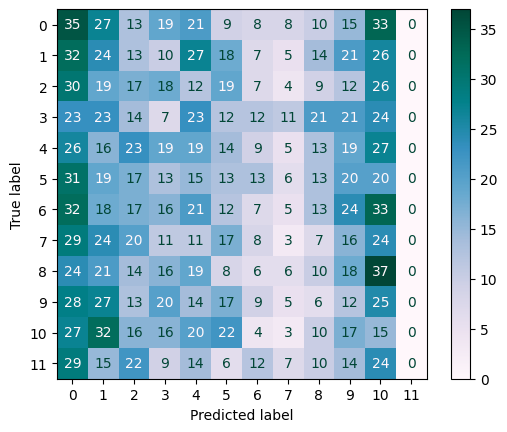

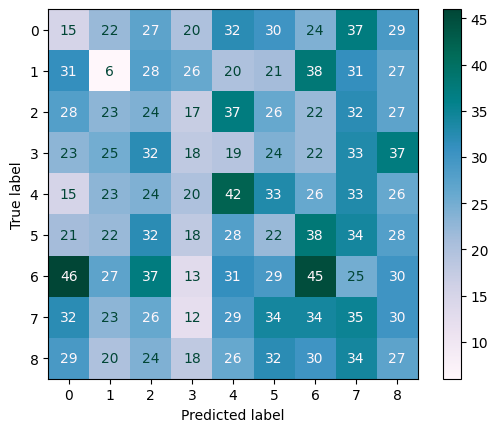

The ROC AUC score of I is: 0.5105560105560105
The ROC AUC score of II is: 0.5006335655137213
The ROC AUC score of III is: 0.5041502490149409
The ROC AUC score of aVR is: 0.47667872204305994
The ROC AUC score of aVL is: 0.5008973080757727
The ROC AUC score of aVF is: 0.4979166666666667
The ROC AUC score of V1 is: 0.49390299390299386
The ROC AUC score of V2 is: 0.4927820684048545
The ROC AUC score of V3 is: 0.4966984542007462
The ROC AUC score of V4 is: 0.4853285328532853
The ROC AUC score of V5 is: 0.46697840391981404
The ROC AUC score of V6 is: 0.5
The ROC AUC score of 1 is: 0.4743817018332757
The ROC AUC score of 2 is: 0.46615586221651695
The ROC AUC score of 3 is: 0.49217398823936354
The ROC AUC score of 4 is: 0.5019480562072154
The ROC AUC score of 5 is: 0.5299703088388303
The ROC AUC score of 6 is: 0.4866397375357949
The ROC AUC score of 7 is: 0.518344819433336
The ROC AUC score of 8 is: 0.501909264478589
The ROC AUC score of 9 is: 0.49643404907975464


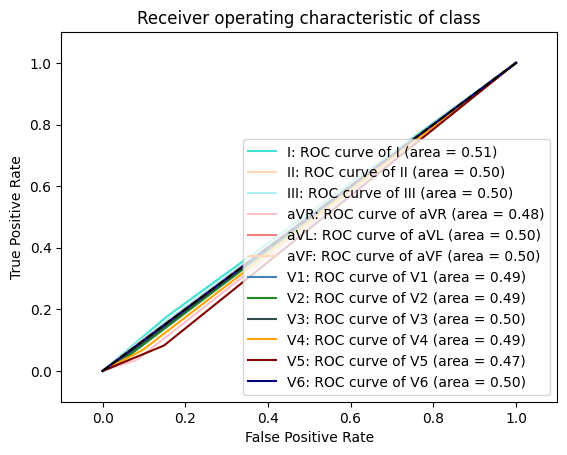

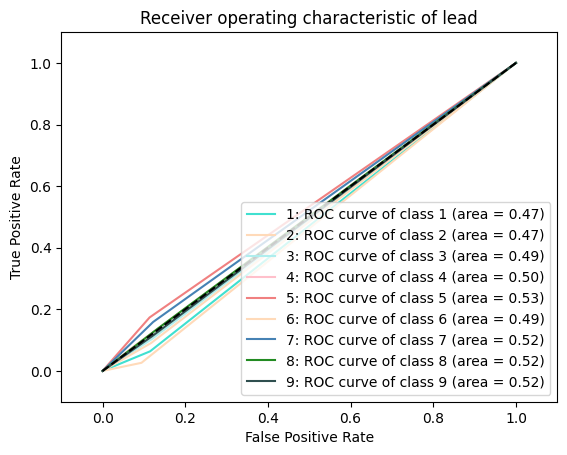

In [27]:
# Metadata

# Training Setup
device = "cuda"
learning_rate = 0.0001
optimizer = "Adam"
loss = "CCE"
# batchsize = 128
epochs = 100
# ratio = (0.8, 0.1, 0.1)

# Data

monitor = Training(device = device,
                   learning_rate = learning_rate,
                   optimizer = optimizer,
                   loss = loss,
                   model = model,
#                    batchsize = batchsize,
                   epochs = epochs)
#                    label_df = label_df, 
#                    root_dir = img_data_dir, 
#                    ratio = ratio)
monitor.__update__()

In [28]:
# Unitest

# monitor.get_sample_count()

In [29]:
# monitor.update()

# Evaluation

In [30]:
# monitor.evaluation()

# Clear Buffer

In [31]:
# monitor.clear_buffer()